# Competitive Analysis Demo

This notebook demonstrates the competitive analysis modules for MYGA products:

1. **Positioning Analysis** - Rate percentiles and distribution
2. **Spread Analysis** - Spreads over Treasury
3. **Company Rankings** - Market rankings and competitive landscape

See: CONSTITUTION.md Section 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import competitive analysis modules
from annuity_pricing.competitive import (
    PositioningAnalyzer,
    SpreadAnalyzer,
    RankingAnalyzer,
    build_treasury_curve,
)
from annuity_pricing.products.myga import MYGAPricer
from annuity_pricing.data.schemas import MYGAProduct

# Set display options
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)

## 1. Generate Sample Market Data

For demonstration, we'll create synthetic market data that mimics WINK patterns.

[T2] Based on typical WINK MYGA distributions:
- 3-year rates: ~4.0-4.5%
- 5-year rates: ~4.3-5.0%
- 7-year rates: ~4.5-5.2%

In [2]:
# Seed for reproducibility
np.random.seed(42)

companies = [
    "Alpha Life", "Beta Insurance", "Gamma Annuity", "Delta Financial",
    "Epsilon Life", "Zeta Insurance", "Eta Annuity", "Theta Financial",
    "Iota Life", "Kappa Insurance"
]

def generate_market_data(n_products=100):
    """Generate synthetic MYGA market data."""
    data = []
    
    for i in range(n_products):
        duration = np.random.choice([3, 5, 7], p=[0.25, 0.50, 0.25])
        
        # Rate depends on duration (longer = higher)
        base_rate = 0.040 + (duration - 3) * 0.003
        rate = np.random.normal(base_rate, 0.004)
        rate = max(0.030, min(0.060, rate))  # Clip to reasonable bounds
        
        data.append({
            'companyName': np.random.choice(companies),
            'productName': f'{duration}-Year MYGA {i+1}',
            'productGroup': 'MYGA',
            'status': 'current',
            'fixedRate': round(rate, 4),
            'guaranteeDuration': duration,
        })
    
    return pd.DataFrame(data)

market_data = generate_market_data(150)
print(f"Generated {len(market_data)} MYGA products")
market_data.head(10)

Generated 150 MYGA products


,companyName,productName,productGroup,status,fixedRate,guaranteeDuration
0,Gamma Annuity,5-Year MYGA 1,MYGA,current,0.0416,5
1,Theta Financial,3-Year MYGA 2,MYGA,current,0.0413,3
2,Epsilon Life,5-Year MYGA 3,MYGA,current,0.0476,5
3,Zeta Insurance,7-Year MYGA 4,MYGA,current,0.0483,7
4,Kappa Insurance,3-Year MYGA 5,MYGA,current,0.0401,3
5,Gamma Annuity,3-Year MYGA 6,MYGA,current,0.0383,3
6,Epsilon Life,5-Year MYGA 7,MYGA,current,0.0459,5
7,Epsilon Life,5-Year MYGA 8,MYGA,current,0.0474,5
8,Kappa Insurance,5-Year MYGA 9,MYGA,current,0.0379,5
9,Delta Financial,3-Year MYGA 10,MYGA,current,0.0445,3


## 2. Positioning Analysis

Analyze where a product's rate falls within the competitive landscape.

In [3]:
# Initialize analyzer
positioning = PositioningAnalyzer()

# Analyze a specific rate
target_rate = 0.045  # 4.5%

# Position for 5-year MYGA
position = positioning.analyze_position(
    rate=target_rate,
    market_data=market_data,
    product_group='MYGA',
    guarantee_duration=5,
)

print("=" * 50)
print("POSITIONING ANALYSIS")
print("=" * 50)
print(f"Rate: {target_rate:.2%}")
print(f"Percentile: {position.percentile:.1f}")
print(f"Rank: {position.rank} of {position.total_products}")
print(f"Quartile: {position.quartile}")
print(f"Position: {position.position_label}")

POSITIONING ANALYSIS
Rate: 4.50%
Percentile: 33.3
Rank: 49 of 72
Quartile: 3
Position: Below Median


In [4]:
# Get distribution statistics
stats = positioning.get_distribution_stats(
    market_data=market_data,
    product_group='MYGA',
    guarantee_duration=5,
)

print("\n" + "=" * 50)
print("5-YEAR MYGA RATE DISTRIBUTION")
print("=" * 50)
print(f"Count: {stats.count}")
print(f"Min: {stats.min:.3%}")
print(f"Max: {stats.max:.3%}")
print(f"Mean: {stats.mean:.3%}")
print(f"Median: {stats.median:.3%}")
print(f"Std Dev: {stats.std:.4%}")
print(f"Q1 (25th): {stats.q1:.3%}")
print(f"Q3 (75th): {stats.q3:.3%}")


5-YEAR MYGA RATE DISTRIBUTION
Count: 72
Min: 3.780%
Max: 5.820%
Mean: 4.647%
Median: 4.695%
Std Dev: 0.4110%
Q1 (25th): 4.350%
Q3 (75th): 4.902%


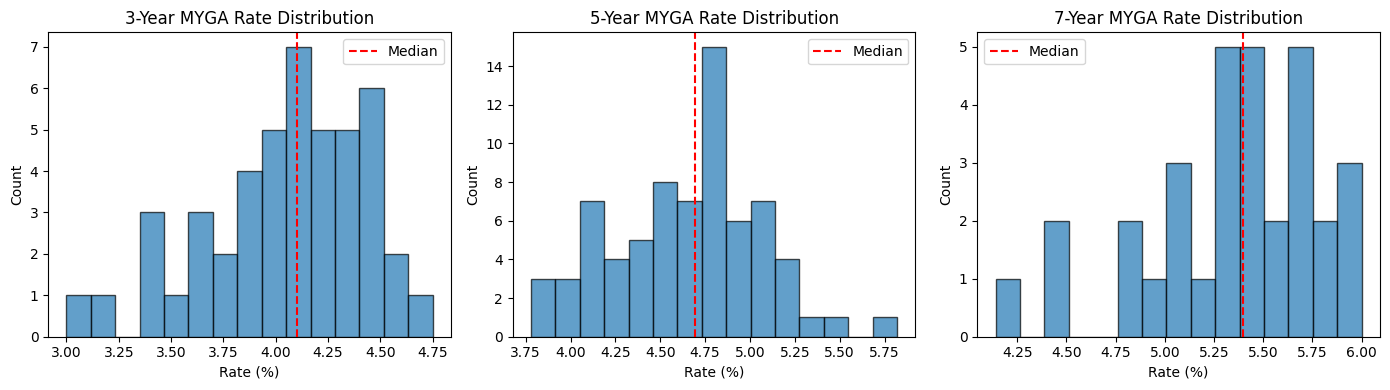

In [5]:
# Visualize rate distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, duration in enumerate([3, 5, 7]):
    duration_data = market_data[
        (market_data['guaranteeDuration'] == duration) &
        (market_data['productGroup'] == 'MYGA')
    ]['fixedRate']
    
    ax = axes[idx]
    ax.hist(duration_data * 100, bins=15, edgecolor='black', alpha=0.7)
    ax.axvline(duration_data.median() * 100, color='red', linestyle='--', label='Median')
    ax.set_xlabel('Rate (%)')
    ax.set_ylabel('Count')
    ax.set_title(f'{duration}-Year MYGA Rate Distribution')
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Spread Analysis

Analyze spreads over Treasury yields.

In [6]:
# Build Treasury curve (sample rates)
treasury_curve = {
    1: 0.035,   # 1-year: 3.5%
    2: 0.037,   # 2-year: 3.7%
    3: 0.038,   # 3-year: 3.8%
    5: 0.040,   # 5-year: 4.0%
    7: 0.042,   # 7-year: 4.2%
    10: 0.044,  # 10-year: 4.4%
}

# Initialize spread analyzer
spread_analyzer = SpreadAnalyzer()

# Calculate spread for a specific product
product_rate = 0.045
duration = 5

spread_result = spread_analyzer.calculate_spread(
    product_rate=product_rate,
    treasury_rate=treasury_curve[duration],
    duration=duration,
)

print("=" * 50)
print("SPREAD ANALYSIS")
print("=" * 50)
print(f"Product Rate: {spread_result.product_rate:.3%}")
print(f"Treasury Rate ({duration}Y): {spread_result.treasury_rate:.3%}")
print(f"Spread: {spread_result.spread_bps:.0f} bps ({spread_result.spread_pct:.1f}% over Treasury)")

SPREAD ANALYSIS
Product Rate: 4.500%
Treasury Rate (5Y): 4.000%
Spread: 50 bps (12.5% over Treasury)


In [7]:
# Calculate spreads for all market products
market_with_spreads = spread_analyzer.calculate_market_spreads(
    market_data=market_data,
    treasury_curve=treasury_curve,
    product_group='MYGA',
)

# Get spread distribution for 5-year products
spread_dist = spread_analyzer.get_spread_distribution(
    market_data=market_data,
    treasury_curve=treasury_curve,
    product_group='MYGA',
    guarantee_duration=5,
)

print("\n" + "=" * 50)
print("5-YEAR MYGA SPREAD DISTRIBUTION")
print("=" * 50)
print(f"Count: {spread_dist.count}")
print(f"Min Spread: {spread_dist.min_bps:.0f} bps")
print(f"Max Spread: {spread_dist.max_bps:.0f} bps")
print(f"Mean Spread: {spread_dist.mean_bps:.0f} bps")
print(f"Median Spread: {spread_dist.median_bps:.0f} bps")
print(f"Std Dev: {spread_dist.std_bps:.1f} bps")


5-YEAR MYGA SPREAD DISTRIBUTION
Count: 72
Min Spread: -22 bps
Max Spread: 182 bps
Mean Spread: 65 bps
Median Spread: 69 bps
Std Dev: 41.1 bps


In [8]:
# Spread by duration analysis
spread_by_duration = spread_analyzer.spread_by_duration(
    market_data=market_data,
    treasury_curve=treasury_curve,
    product_group='MYGA',
)

print("\n" + "=" * 50)
print("SPREAD BY DURATION")
print("=" * 50)
print(spread_by_duration.to_string(index=False))


SPREAD BY DURATION
 guaranteeDuration  count  mean_spread_bps  median_spread_bps  std_bps  min_bps  max_bps
                 3     46             24.7               30.0     38.8    -80.0     95.0
                 5     72             64.7               69.5     41.1    -22.0    182.0
                 7     32            113.8              119.5     45.8     -6.0    180.0


## 4. Company Rankings

Analyze company competitive positioning and market rankings.

In [9]:
# Initialize ranking analyzer
ranking_analyzer = RankingAnalyzer()

# Get market summary
summary = ranking_analyzer.market_summary(market_data, product_group='MYGA')

print("=" * 50)
print("MARKET SUMMARY")
print("=" * 50)
print(f"Total Products: {summary['total_products']}")
print(f"Total Companies: {summary['total_companies']}")
print(f"Rate Range: {summary['rate_min']:.3%} - {summary['rate_max']:.3%}")
print(f"Mean Rate: {summary['rate_mean']:.3%}")
print(f"Median Rate: {summary['rate_median']:.3%}")
print(f"Durations Available: {summary['durations_available']}")

MARKET SUMMARY
Total Products: 150
Total Companies: 10
Rate Range: 3.000% - 6.000%
Mean Rate: 4.611%
Median Rate: 4.590%
Durations Available: [3, 5, 7]


In [10]:
# Rank companies by best rate (5-year products)
company_rankings = ranking_analyzer.rank_companies(
    market_data=market_data,
    product_group='MYGA',
    guarantee_duration=5,
    rank_by='best_rate',
)

print("\n" + "=" * 50)
print("COMPANY RANKINGS (5-Year MYGA, by Best Rate)")
print("=" * 50)
print(f"{'Rank':<6}{'Company':<20}{'Best Rate':<12}{'Avg Rate':<12}{'Products':<10}")
print("-" * 60)

for r in company_rankings[:10]:
    print(f"{r.rank:<6}{r.company:<20}{r.best_rate:.3%}       {r.avg_rate:.3%}       {r.product_count}")


COMPANY RANKINGS (5-Year MYGA, by Best Rate)
Rank  Company             Best Rate   Avg Rate    Products  
------------------------------------------------------------
1     Zeta Insurance      5.820%       4.726%       5
2     Epsilon Life        5.450%       4.769%       10
3     Delta Financial     5.240%       4.838%       6
4     Gamma Annuity       5.230%       4.592%       10
5     Beta Insurance      5.220%       4.856%       5
6     Kappa Insurance     5.130%       4.453%       9
7     Eta Annuity         5.030%       4.572%       6
8     Iota Life           5.020%       4.583%       6
9     Alpha Life          4.900%       4.647%       12
10    Theta Financial     4.600%       4.430%       3


In [11]:
# Rate leaders by duration
leaders = ranking_analyzer.rate_leaders_by_duration(
    market_data=market_data,
    product_group='MYGA',
)

print("\n" + "=" * 50)
print("RATE LEADERS BY DURATION")
print("=" * 50)

for duration in sorted(leaders['duration'].unique()):
    print(f"\n{duration}-Year MYGA:")
    duration_leaders = leaders[leaders['duration'] == duration]
    for _, row in duration_leaders.iterrows():
        print(f"  #{int(row['rank'])}: {row['company']:<18} {row['rate']:.3%}")


RATE LEADERS BY DURATION

3-Year MYGA:
  #1: Iota Life          4.750%
  #2: Alpha Life         4.630%
  #3: Epsilon Life       4.590%

5-Year MYGA:
  #1: Zeta Insurance     5.820%
  #2: Epsilon Life       5.450%
  #3: Epsilon Life       5.320%

7-Year MYGA:
  #1: Eta Annuity        6.000%
  #2: Eta Annuity        5.990%
  #3: Iota Life          5.930%


In [12]:
# Competitive landscape
landscape = ranking_analyzer.competitive_landscape(
    market_data=market_data,
    product_group='MYGA',
    guarantee_duration=5,
)

print("\n" + "=" * 50)
print("COMPETITIVE LANDSCAPE (5-Year MYGA)")
print("=" * 50)
print(landscape[['companyName', 'rank', 'best_rate', 'avg_rate', 'tier', 'rate_percentile']].to_string(index=False))


COMPETITIVE LANDSCAPE (5-Year MYGA)
    companyName  rank  best_rate  avg_rate        tier  rate_percentile
 Zeta Insurance     1     0.0582    0.0473      Leader            100.0
   Epsilon Life     2     0.0545    0.0477      Leader             90.0
Delta Financial     3     0.0524    0.0484      Leader             80.0
  Gamma Annuity     4     0.0523    0.0459 Competitive             70.0
 Beta Insurance     5     0.0522    0.0486 Competitive             60.0
Kappa Insurance     6     0.0513    0.0445 Competitive             50.0
    Eta Annuity     7     0.0503    0.0457    Follower             40.0
      Iota Life     8     0.0502    0.0458    Follower             30.0
     Alpha Life     9     0.0490    0.0465    Follower             20.0
Theta Financial    10     0.0460    0.0443    Follower             10.0


## 5. Rate Recommendation

Use the rate recommender to suggest competitive rates.

In [13]:
from annuity_pricing.rate_setting.recommender import RateRecommender

recommender = RateRecommender()

# Get rate recommendations for different target percentiles
print("=" * 60)
print("RATE RECOMMENDATIONS (5-Year MYGA)")
print("=" * 60)
print(f"{'Target Percentile':<20}{'Recommended Rate':<18}{'Spread (bps)':<15}")
print("-" * 55)

for target in [50, 75, 90, 95]:
    rec = recommender.recommend_rate(
        guarantee_duration=5,
        target_percentile=target,
        market_data=market_data,
        treasury_rate=treasury_curve[5],
    )
    spread = rec.spread_over_treasury or 0
    print(f"{target}th percentile      {rec.recommended_rate:.3%}           {spread:.0f}")

RATE RECOMMENDATIONS (5-Year MYGA)
Target Percentile   Recommended Rate  Spread (bps)   
-------------------------------------------------------
50th percentile      4.695%           69
75th percentile      4.902%           90
90th percentile      5.124%           112
95th percentile      5.235%           123


In [14]:
# Sensitivity analysis
sensitivity = recommender.sensitivity_analysis(
    guarantee_duration=5,
    market_data=market_data,
    treasury_rate=treasury_curve[5],
    percentile_range=[25, 50, 75, 90],
)

print("\n" + "=" * 60)
print("SENSITIVITY ANALYSIS")
print("=" * 60)
print(sensitivity[['percentile', 'rate', 'spread_bps', 'margin_bps']].to_string(index=False))


SENSITIVITY ANALYSIS
 percentile     rate  spread_bps  margin_bps
         25 0.043500       35.00      -15.00
         50 0.046950       69.50       19.50
         75 0.049025       90.25       40.25
         90 0.051240      112.40       62.40


## Summary

This notebook demonstrated the competitive analysis modules:

1. **PositioningAnalyzer**: Rate percentile analysis and distribution statistics
2. **SpreadAnalyzer**: Spread over Treasury calculations and market spread distributions
3. **RankingAnalyzer**: Company rankings, market summary, and competitive landscape
4. **RateRecommender**: Rate recommendations for target competitive percentiles

### Key Insights

- **Positioning**: Understand where a product rate falls in the competitive landscape
- **Spreads**: Track spread over Treasury to assess margin and competitiveness
- **Rankings**: Monitor competitive positioning relative to peers
- **Recommendations**: Set rates to achieve target competitive percentiles